## Silhouette analyses

List of representations:
 - Uncoupled $z_t$ and $z_e$ 
 - Coupled $z_t$ and $z_e$

Label sets:
 - Reference transcriptomic taxonomy (i.e. 53 cell type labels)
 - 33 component GMM fit on coupled representations (unsupervised clustering suggested 33 clusters)
 - 33-way reference taxonomy (Reference transcriptomic taxonomy is a hierarchical tree. We perform a cut of this tree such that 33 leaf nodes remain)

We use silhouette scores to:
1. show that consensus clusters capture structure in the aligned transcriptomic and electrophysiological latent space better compared to a transcriptomic-based reference taxonomy partitioning and 2. identify clusters that are "unstable" among the consensus clusters

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

from cplAE_TE.utils.load_helpers import get_paths ,load_dataset, load_summary_files, taxonomy_assignments
from cplAE_TE.utils.compute import silhouette_analysis

In [2]:
path=get_paths()
O = load_dataset()    
folds_0 = load_summary_files(data_type='NM_cc',lambda_TE=0.0, aug=0, load_gmm=False)
folds_1 = load_summary_files(data_type='NM_cc',lambda_TE=1.0, aug=1, load_gmm=True)

Select best coupled models based on reconstruction error in test set

In [3]:
#For uncoupled autoencoders (i.e. standalone autoencoders for individual modalities)
T_criteria=[]
E_criteria=[]
for i in folds_0.keys():
    T_mse = np.mean((folds_0[i]['XrT']-O['XT'])**2, axis=1)
    E_mse = np.sum(O['maskE']*(folds_0[i]['XrE']-O['XE'])**2, axis=1)/np.sum(O['maskE'], axis=1)
    test_ind = folds_0[i]['test_ind']
    T_criteria.append(np.mean(T_mse[test_ind]))
    E_criteria.append(np.mean(E_mse[test_ind]))

# pick 5 of the best models based on criteria
n_best_models = 5
fold_id = np.array(list(folds_0.keys()))
best_T_model_keys = fold_id[np.argsort(T_criteria)][0:n_best_models]
best_E_model_keys = fold_id[np.argsort(E_criteria)][0:n_best_models]
print(f'Best {n_best_models} T autoencoder keys: {best_T_model_keys}')
print(f'Best {n_best_models} E autoencoder keys: {best_E_model_keys}')

Best 5 T autoencoder keys: [ 3  1 10 17 12]
Best 5 E autoencoder keys: [11 10  3  0  9]


Select the best coupled models based on reconstruction error in test set

In [4]:
#For coupled autoencoders:
criteria = []
for i in folds_1.keys():
    # pre-calculate errors
    T_mse = np.mean((folds_1[i]['XrT']-O['XT'])**2, axis=1)
    E_mse = np.sum(O['maskE']*(folds_1[i]['XrE']-O['XE'])**2, axis=1)/np.sum(O['maskE'], axis=1)

    # inliers are defined based on test+train:
    perc = 95
    test_inds = folds_1[i]['test_ind']
    T_inlier = np.flatnonzero(T_mse < np.percentile(T_mse, perc))
    E_inlier = np.flatnonzero(E_mse < np.percentile(E_mse, perc))
    TE_inliers = np.intersect1d(E_inlier, T_inlier)
    inlier_test_inds = np.intersect1d(test_inds, TE_inliers)

    # alpha_T = alpha_E = 1 in the loss function. Therefore, we simply add the T and E reconstruction losses.
    criteria.append(np.mean(T_mse[inlier_test_inds]) +
                    np.mean(E_mse[inlier_test_inds]))

# pick 5 of the best models based on criteria
n_best_models = 5
fold_id = np.array(list(folds_1.keys()))
best_TE_model_keys = np.argsort(criteria)
best_TE_model_keys = fold_id[best_TE_model_keys][0:n_best_models]
print(f'Best {n_best_models} coupled model keys: {best_TE_model_keys}')

Best 5 coupled model keys: [11 17  1 14 10]


#### Overall average silhouette scores on test cells with uncoupled representations

In [5]:
#Uncoupled zE with different resolution of taxonomy:
s_mean_list_E_to_tax = []
s_mean_list_T_to_tax = []
n_classes_list = []
n_best_models = 5

for n_required_classes in np.arange(10, 54, 1):
    merged_labels, n_classes = taxonomy_assignments(initial_labels=deepcopy(O['cluster']),
                                                    datadict=deepcopy(O),
                                                    n_required_classes=n_required_classes,
                                                    merge_on='well_sampled')
    for k in range(n_best_models):
        n_classes_list.append(n_classes)
        all_inds = O['well_sampled_ind'].copy()
        test_inds = folds_0[best_E_model_keys[k]
                            ]['well_sampled_test_ind'].copy()

        zE = folds_0[best_E_model_keys[k]]['zE'][test_inds, :].copy()
        lbl = merged_labels[test_inds].copy()
        df_E_sample, df_E_label = silhouette_analysis(z=zE, lbl=lbl)
        s_mean_list_E_to_tax.append(df_E_sample['sil'].mean())

        zT = folds_0[best_T_model_keys[k]]['zT'][test_inds, :].copy()
        lbl = merged_labels[test_inds].copy()
        df_T_sample, df_T_label = silhouette_analysis(z=zT, lbl=lbl)
        s_mean_list_T_to_tax.append(df_T_sample['sil'].mean())

df = pd.DataFrame({'sil_E': s_mean_list_E_to_tax,
                   'sil_T': s_mean_list_T_to_tax, 'n_classes': n_classes_list})
df_n_class = df.groupby('n_classes').agg([np.mean, np.std]).reset_index()
df_n_class = df_n_class.loc[df_n_class['n_classes'] > 25]

Markdown - storing source data script

```
x = df_n_class['n_classes'].values
y = df_n_class['sil_T']['mean'].values
std = df_n_class['sil_T']['std'].values
df = pd.DataFrame({'x':x,'y':y,'std':std})
df.to_csv(fig_path+'Source_data_Fig_Ed_8a.csv',index=False)

x = df_n_class['n_classes'].values
y = df_n_class['sil_E']['mean'].values
std = df_n_class['sil_E']['std'].values
df = pd.DataFrame({'x':x,'y':y,'std':std})
df.to_csv(fig_path+'Source_data_Fig_Ed_8b.csv',index=False)
```

#### Clusters 

 - The reference taxonomy was obtained based analysis of gene expression alone (Tasic et al. 2018)
 - The set of labels obtained by 
 - These labels agree with clusters in a low dimensional representation for the transcriptomic data (uncoupled $z_t$)
 - These labels agree with clusters in a low dimensional representation for the transcriptomic data (uncoupled $z_t$)


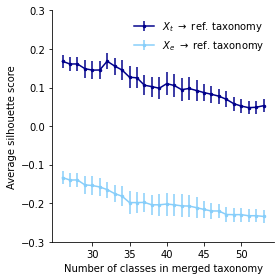

In [6]:

plt.figure(figsize=(4, 4))
plt.errorbar(df_n_class['n_classes'].values, df_n_class['sil_T']['mean'].values, df_n_class['sil_T']['std'].values,
             color='darkblue', label=r'$X_{t}$ $\rightarrow$ ref. taxonomy',
             linestyle='-', marker='.', ms=5)
plt.errorbar(df_n_class['n_classes'].values, df_n_class['sil_E']['mean'].values, df_n_class['sil_T']['std'].values,
             color='lightskyblue', label=r'$X_{e}$ $\rightarrow$ ref. taxonomy',
             linestyle='-', marker='.', ms=5)

ax = plt.gca()
ax.set(**{'xlabel': ('Number of classes in merged taxonomy'),
          'ylabel': ('Average silhouette score'),
          'xticks': (np.arange(30, 55, 5)),
          'ylim': (-0.3, 0.3)})
plt.legend(frameon=False)
plt.tight_layout()
sns.despine()
plt.show()

#### Coupled representations with GMM labels and 33-taxonomy

In [7]:
df_sample_list_E_gmm= []
df_label_list_E_gmm = []

df_sample_list_T_gmm = []
df_label_list_T_gmm = []

df_sample_list_E_tax= []
df_label_list_E_tax = []

df_sample_list_T_tax = []
df_label_list_T_tax = []

tax_labels,n_classes = taxonomy_assignments(deepcopy(O['cluster']),
                                            datadict=deepcopy(O),
                                            n_required_classes=33, 
                                            merge_on='well_sampled')

for k in range(n_best_models):
    all_inds = O['well_sampled_ind'].copy()
    test_inds = folds_1[best_TE_model_keys[k]]['well_sampled_test_ind'].copy()
    
    #zE -> Gmm E
    zE = folds_1[best_TE_model_keys[k]]['zE'][test_inds,:].copy()
    lbl = folds_1[best_TE_model_keys[k]]['ccE_lbl_matched'][test_inds].copy()
    df_sample,df_label = silhouette_analysis(z=zE,lbl=lbl)
    df_sample_list_E_gmm.append(df_sample)
    df_label_list_E_gmm.append(df_label)
    
    #zE -> taxonomy
    zE = folds_1[best_TE_model_keys[k]]['zE'][test_inds,:].copy()
    lbl = tax_labels.copy()[test_inds]
    df_sample,df_label = silhouette_analysis(z=zE,lbl=lbl)
    df_sample_list_E_tax.append(df_sample)
    df_label_list_E_tax.append(df_label)
    
    #zT -> Gmm T
    zT = folds_1[best_TE_model_keys[k]]['zT'][test_inds,:].copy()
    lbl = folds_1[best_TE_model_keys[k]]['ccT_lbl_matched'][test_inds].copy()
    df_sample,df_label = silhouette_analysis(z=zT,lbl=lbl)
    df_sample_list_T_gmm.append(df_sample)
    df_label_list_T_gmm.append(df_label)
    
    #zT -> taxonomy
    zT = folds_1[best_TE_model_keys[k]]['zT'][test_inds,:].copy()
    lbl = tax_labels.copy()[test_inds]
    df_sample,df_label = silhouette_analysis(z=zT,lbl=lbl)
    df_sample_list_T_tax.append(df_sample)
    df_label_list_T_tax.append(df_label)

In [8]:
s_tax_coupled = np.array([df['sil'].mean() for df in df_sample_list_E_gmm])
print(f'Coupled E rep. with GMM: s = {np.mean(s_tax_coupled):0.3f} + {np.std(s_tax_coupled):0.3f}')

s_tax_coupled = np.array([df['sil'].mean() for df in df_sample_list_T_gmm])
print(f'Coupled T rep. with GMM: s = {np.mean(s_tax_coupled):0.3f} + {np.std(s_tax_coupled):0.3f}')

s_tax_coupled = np.array([df['sil'].mean() for df in df_sample_list_E_tax])
print(f'Coupled E rep. with taxonomy: s = {np.mean(s_tax_coupled):0.3f} + {np.std(s_tax_coupled):0.3f}')

s_tax_coupled = np.array([df['sil'].mean() for df in df_sample_list_T_tax])
print(f'Coupled T rep. with taxonomy: s = {np.mean(s_tax_coupled):0.3f} + {np.std(s_tax_coupled):0.3f}')

Coupled E rep. with GMM: s = 0.044 + 0.017
Coupled T rep. with GMM: s = 0.235 + 0.009
Coupled E rep. with taxonomy: s = -0.133 + 0.008
Coupled T rep. with taxonomy: s = 0.135 + 0.009


#### Uncoupled representation with 33-label taxonomy

In [9]:
df_sample_list_E_tax_unc = []
df_label_list_E_tax_unc = []

df_sample_list_T_tax_unc = []
df_label_list_T_tax_unc = []

tax_labels,n_classes = taxonomy_assignments(O['cluster'].copy(),datadict=O.copy(),n_required_classes=33, merge_on='well_sampled')

for i in folds_0.keys():
    
    zE = folds_0[i]['zE'][test_inds,:].copy()
    lbl = tax_labels.copy()[test_inds]
    df_sample,df_label = silhouette_analysis(z=zE,lbl=lbl)
    df_sample_list_E_tax_unc.append(df_sample)
    df_label_list_E_tax_unc.append(df_label)
    
    zT = folds_1[i]['zT'][test_inds,:].copy()
    lbl = tax_labels.copy()[test_inds]
    df_sample,df_label = silhouette_analysis(z=zT,lbl=lbl)
    df_sample_list_T_tax_unc.append(df_sample)
    df_label_list_T_tax_unc.append(df_label)

In [10]:
s_tax_unc = np.array([df['sil'].mean() for df in df_sample_list_T_tax_unc])
print(f'Silhouette score for Uncoupled zT with 33-way reference taxonomy: s = {np.mean(s_tax_unc):0.3f} + {np.std(s_tax_unc):0.3f}')

s_tax_unc = np.array([df['sil'].mean() for df in df_sample_list_E_tax_unc])
print(f'Silhouette score Uncoupled zE with 33-way reference taxonomy: s = {np.mean(s_tax_unc):0.3f} + {np.std(s_tax_unc):0.3f}')

Silhouette score for Uncoupled zT with 33-way reference taxonomy: s = 0.132 + 0.022
Silhouette score Uncoupled zE with 33-way reference taxonomy: s = -0.188 + 0.026


In [11]:
x = np.mean(df_label_list_E_gmm[0]["sil"]["mean"].values)
y = np.std(df_label_list_E_gmm[0]["sil"]["mean"].values)
print(f'Silhouette score for coupled zE with 33 consensus clusters:   {x:0.2f} + {y:0.2f}')

x=np.mean(df_label_list_E_tax[0]['sil']['mean'].values)
y=np.std(df_label_list_E_tax[0]['sil']['mean'].values)
print(f'Silhouette score for coupled zE with 33-way reference taxonomy:   {x:0.2f} + {y:0.2f}')

Silhouette score for coupled zE with 33 consensus clusters:   0.10 + 0.28
Silhouette score for coupled zE with 33-way reference taxonomy:   -0.17 + 0.28


In [12]:
# write data files
df_csv = pd.DataFrame({'consensus_lbl':df_label_list_E_gmm[0]['sil']['mean'].values,
                       'reference_lbl':df_label_list_E_tax[0]['sil']['mean'].values,
                       'reference_lbl_unc':df_label_list_E_tax_unc[0]['sil']['mean'].values})
df_csv.to_csv(path['package'] / 'assets/Fig_3e_source.csv',index=True)

df_csv = pd.DataFrame({'consensus_lbl':df_label_list_T_gmm[0]['sil']['mean'].values,
                       'reference_lbl':df_label_list_T_tax[0]['sil']['mean'].values,
                       'reference_lbl_unc':df_label_list_T_tax_unc[0]['sil']['mean'].values})
df_csv.to_csv(path['package'] / 'assets/Fig_3d_source.csv',index=True)

In [13]:
import seaborn as sns
sns.set()
sns.set_style('ticks',{'axes.grid' : False}) 
%matplotlib inline

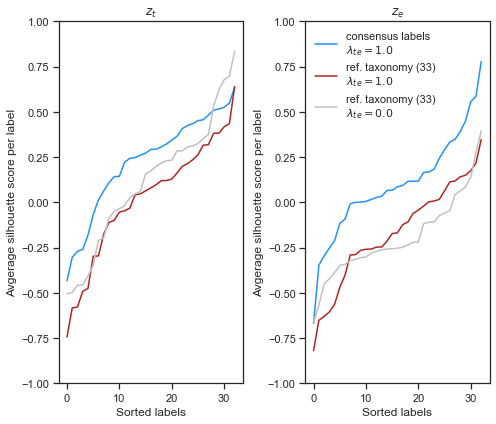

In [14]:
col=['dodgerblue','firebrick','silver']
plt.figure(figsize=(7,6))

plt.subplot(121)
plt.plot(df_label_list_T_gmm[0]['sil']['mean'].values, color=col[0],label=r'consensus labels'+'\n'+ r'$\lambda_{te}=1.0$')
plt.plot(df_label_list_T_tax[0]['sil']['mean'].values, color=col[1],label=r'ref. taxonomy (33)'+'\n'+ r'$\lambda_{te}=1.0$')
plt.plot(df_label_list_T_tax_unc[0]['sil']['mean'].values, color=col[2],label=r'ref. taxonomy (33)'+'\n'+ r'$\lambda_{te}=0.0$')
ax = plt.gca()
ax.set(**{'title':r'$z_t$',
        'xlabel':'Sorted labels',
        'ylabel':'Avgerage silhouette score per label',
        'ylim':(-1,1)})

plt.subplot(122)
plt.plot(df_label_list_E_gmm[0]['sil']['mean'].values, color=col[0],label=r'consensus labels'+'\n'+ r'$\lambda_{te}=1.0$')
plt.plot(df_label_list_E_tax[0]['sil']['mean'].values, color=col[1],label=r'ref. taxonomy (33) '+'\n'+ r'$\lambda_{te}=1.0$')
plt.plot(df_label_list_E_tax_unc[0]['sil']['mean'].values, color=col[2],label=r'ref. taxonomy (33) '+'\n'+ r'$\lambda_{te}=0.0$')
ax = plt.gca()
ax.set(**{'title':r'$z_e$',
        'xlabel':'Sorted labels',
        'ylabel':'Avgerage silhouette score per label',
        'ylim':(-1,1)})

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [15]:
x = df_label_list_T_gmm[0]["sil"]["mean"].mean()
y = df_label_list_T_gmm[0]["sil"]["mean"].std()
print(f'Consensus    {x:0.2f} + {y:0.2f}')

x=df_label_list_T_tax[0]['sil']['mean'].mean()
y=df_label_list_T_tax[0]['sil']['mean'].std()
print(f'Taxonomy 33   {x:0.2f} + {y:0.2f}')

Consensus    0.23 + 0.28
Taxonomy 33   0.02 + 0.33


#### Identify _unreliable_ clusters


In [16]:
n_worst=10
unreliable_clusters = np.intersect1d(df_label_list_T_gmm[0][0:n_worst]['lbl'].values,df_label_list_E_gmm[0][0:n_worst]['lbl'].values)
print(df_label_list_E_gmm[0][df_label_list_E_gmm[0]['lbl'].isin(unreliable_clusters)])
print("=========================")
print(df_label_list_T_gmm[0][df_label_list_T_gmm[0]['lbl'].isin(unreliable_clusters)])

  lbl       sil          
           mean       std
0   1 -0.668872  0.154438
1  13 -0.347262  0.134515
2   9 -0.296254  0.112122
3  28 -0.253059  0.193271
4   7 -0.211839  0.200849
6  17 -0.092525  0.150189
9  24  0.001514  0.190524
  lbl       sil          
           mean       std
0   1 -0.433628  0.335519
1   7 -0.304104  0.206137
2   9 -0.270276  0.086487
3  13 -0.260740  0.212850
4  28 -0.181354  0.198278
6  17  0.013605  0.284825
9  24  0.141834  0.236050
